### **Group members: Xuanyang Wang, Bowen Tan**

## **Introduction**

###*Background*
This spring, a small discussion group in Reddit called WallStreetBets invoked great impact on the stock market. The entire market was shocked by the prediction and operations on certain stocks like GME and AMC led by some users within this discussion group. We therefore decided to use data analysis skill to find out what do they talk about in their discussions.

###*Project Goal*
In this project, we are trying to look at the data set that contains posts from Wall Street Bets. We are aiming to find out the reason behind high-score and high-comment posts, and find out trend of posts within the group. We also want to train models that help predict what kind of posts would users in this group most likely to view.

###*Data set*
We found two separate datasets on kaggle that contain the posts from r/wallstreetbets. The larger one is 200MB, the smaller one is 30MB. We are mainly studying the smaller data set in the following EDA.

In [38]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT, force_remount=True)

# create folder to write data to
CIS545_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS545_2021')
FOLDER=os.path.join(CIS545_FOLDER, 'final')
os.makedirs(FOLDER, exist_ok=True)

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/gdrive


In [39]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/gdrive/MyDrive/CIS545_2021/final/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat '/content/gdrive/MyDrive/CIS545_2021/final/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# ! kaggle datasets list

In [ ]:
# !kaggle datasets download -d unanimad/reddit-rwallstreetbets -p /content/gdrive/MyDrive/CIS545_2021/final
# !kaggle datasets download -d gpreda/reddit-wallstreetsbets-posts -p /content/gdrive/MyDrive/CIS545_2021/final

# !unzip /content/gdrive/MyDrive/CIS545_2021/final/reddit-rwallstreetbets.zip -d /content/gdrive/MyDrive/CIS545_2021/final/data_1
# !unzip /content/gdrive/MyDrive/CIS545_2021/final/reddit-wallstreetsbets-posts.zip -d /content/gdrive/MyDrive/CIS545_2021/final/data_2

In [40]:
import pandas as pd

data_1_df = pd.read_csv('/content/gdrive/MyDrive/CIS545_2021/final/data_1/r_wallstreetbets_posts.csv')#bigger 
data_2_df = pd.read_csv('/content/gdrive/MyDrive/CIS545_2021/final/data_2/reddit_wsb.csv')# smaller

In [41]:
!pip install pandasql

import pandasql as ps
import nltk

In [42]:
query = '''
SELECT * FROM data_2_df
WHERE
title IS NOT NULL
AND
score IS NOT NULL
AND
id IS NOT NULL
AND
comms_num IS NOT NULL
AND
created IS NOT NULL
AND
timestamp IS NOT NULL
'''

data_2_clean = ps.sqldf(query, locals())

data_2_clean

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,None,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,None,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,None,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,None,2021-01-28 21:26:56
...,...,...,...,...,...,...,...,...
45418,"$ERIC, your wife's new boyfriend",49,mpdlqm,https://www.reddit.com/r/wallstreetbets/commen...,29,1.618262e+09,"# \n\n5G is the next market to be in, 5G got p...",2021-04-13 00:15:06
45419,Where are all these people now?,108,mpdq3f,https://www.reddit.com/gallery/mpdq3f,28,1.618263e+09,None,2021-04-13 00:21:51
45420,WSB Rules - Please Read Before Posting,193,mpdluv,https://www.reddit.com/r/wallstreetbets/commen...,36,1.618262e+09,# Welcome to WSB!\n\n\---\n\nAdditional readin...,2021-04-13 00:15:17
45421,the 'Buffett Indicator' is Flashing again...Sh...,521,mpd8c2,https://www.reddit.com/r/wallstreetbets/commen...,331,1.618261e+09,(This text is lifted from Yahoo's Mile Udland....,2021-04-12 23:54:14


## **EDA**

###**Data Set 2**

In this dataset, we noticed that even though it contains the 'body' of each posts, more than 50% of the body is just invalid as shown in the picture below:

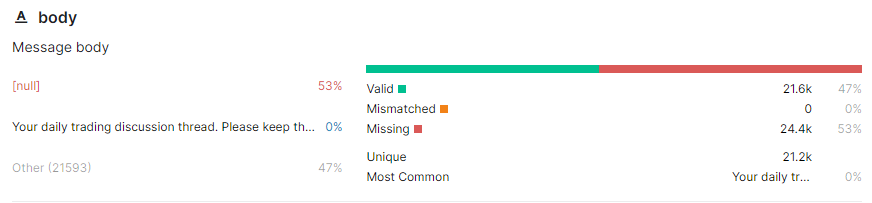

We therefore decide to change the 'body' column as binary value (has body or not) and mainly use the title column to identify the content within the post.

In [43]:
#Change body to 'have_body'

print(data_2_clean['body'])

def to_binary(input):
  if input is None:
    return 0
  else:
    return 1

data_2_clean['have_body'] = data_2_clean['body'].apply(to_binary)

0                                                     None
1                                                     None
2        The CEO of NASDAQ pushed to halt trading “to g...
3                                                     None
4                                                     None
                               ...                        
45418    # \n\n5G is the next market to be in, 5G got p...
45419                                                 None
45420    # Welcome to WSB!\n\n\---\n\nAdditional readin...
45421    (This text is lifted from Yahoo's Mile Udland....
45422                                                 None
Name: body, Length: 45423, dtype: object


We first convert the timestamp into month and year. As we can see, all the posts from data set 1 are from 2021 between end of January and mid April. 

In [48]:
data_2_clean['datetime'] = pd.to_datetime(data_2_clean['timestamp'])
data_2_clean['year'] = data_2_clean['datetime'].dt.year
data_2_clean['month'] = data_2_clean['datetime'].dt.month_name()
data_2_clean['day'] = data_2_clean['datetime'].dt.day
data_2_clean = data_2_clean.drop(columns=['timestamp', 'body', 'url'])
data_2_clean

,title,score,id,comms_num,created,have_body,datetime,year,month,day
0,"It's not about the money, it's about sending a...",55,l6ulcx,6,1.611863e+09,0,2021-01-28 21:37:41,2021,January,28
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,23,1.611862e+09,0,2021-01-28 21:32:10,2021,January,28
2,Exit the system,0,l6uhhn,47,1.611862e+09,1,2021-01-28 21:30:35,2021,January,28
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,74,1.611862e+09,0,2021-01-28 21:28:57,2021,January,28
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,156,1.611862e+09,0,2021-01-28 21:26:56,2021,January,28
...,...,...,...,...,...,...,...,...,...,...
45418,"$ERIC, your wife's new boyfriend",49,mpdlqm,29,1.618262e+09,1,2021-04-13 00:15:06,2021,April,13
45419,Where are all these people now?,108,mpdq3f,28,1.618263e+09,0,2021-04-13 00:21:51,2021,April,13
45420,WSB Rules - Please Read Before Posting,193,mpdluv,36,1.618262e+09,1,2021-04-13 00:15:17,2021,April,13
45421,the 'Buffett Indicator' is Flashing again...Sh...,521,mpd8c2,331,1.618261e+09,1,2021-04-12 23:54:14,2021,April,12


As we plot the count of posts against the month, we found that the number of posts gradually decreases over the year, and there are some random posts from september. We therefore decide to drop those data since we are focusing on the posts in WSB between January and April.

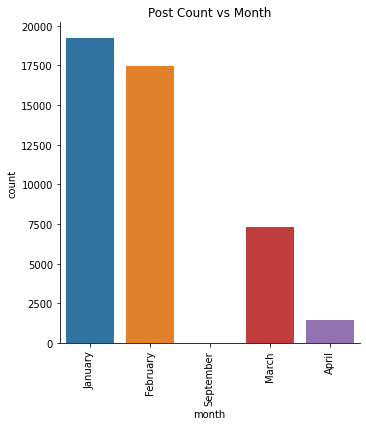

In [49]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import glob
import seaborn as sns
data_2_clean['month'] = data_2_clean['datetime'].dt.month_name()
plot1 = sns.catplot(data=data_2_clean, x='month', kind='count')
plot1.set_xticklabels(rotation=90)
plot1 = plt.title('Post Count vs Month')

After we dropped the September data, we replot the Post Count against Month. It seems that January and Febuary are the month when most posts came out.

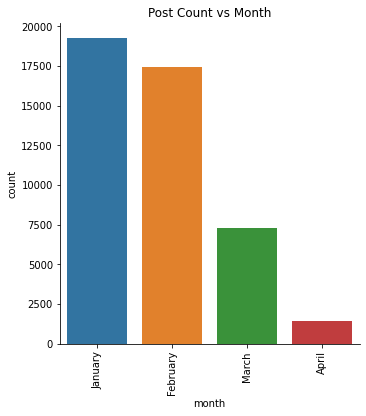

In [50]:
data_2_clean = data_2_clean[data_2_clean['month'] != 'September']
plot1 = sns.catplot(data=data_2_clean, x='month', kind='count')
plot1.set_xticklabels(rotation=90)
plot1 = plt.title('Post Count vs Month')

Since the score and comment numbers are having great range as we observed from the data set above, we decided to take log scale on both the data here. After that, we plot the distribution of them and found that it is heavily headed. This is mostly likely because most of the posts does not get comments. The scores are in general higher because users tend to like/dislike a post but would only comment on really interesting/controversy ones.

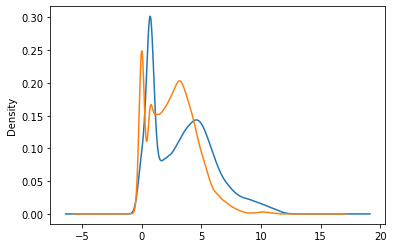

In [51]:
import numpy as np
data_2_clean['score_log'] = data_2_clean['score'].add(1).apply(np.log)
data_2_clean['comms_log'] = data_2_clean['comms_num'].add(1).apply(np.log)
score_log_plot = data_2_clean['score_log'].plot.kde()
comms_log_plot = data_2_clean['comms_log'].plot.kde()

Then, we plotted the score_log and comms_log verses the month as box plots. As we can observe, the fewer the post in a month, the higher the 'quality' of those posts would be, since they tend to have higher score and number of comments on average.

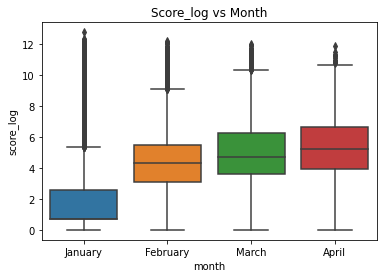

In [52]:
plot2 = sns.boxplot(data=data_2_clean, x='month', y='score_log')
plot2 = plt.title('Score_log vs Month')

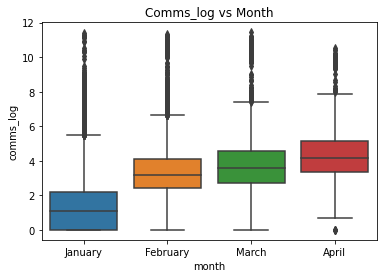

In [53]:
plot3 = sns.boxplot(data=data_2_clean, x='month', y='comms_log')
plot3 = plt.title('Comms_log vs Month')

In plot4, we can see that score and number of comments are postively related in general (which would be further verified in later part), and we can see that the post with highest score was in January, and the post with most comments was in March.

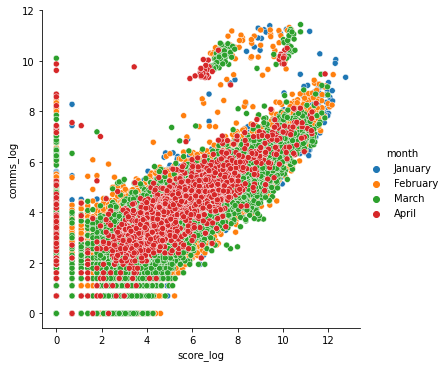

In [54]:
plot4 = sns.relplot(x='score_log', y='comms_log', hue='month', data=data_2_clean)

We then aim to find the TOP 10 post with most mean score and comment numbers:

In [59]:
# Post with most awards / score
# no author for data_2

query = '''
SELECT id, score as score, sum(comms_num) as sum_comms FROM data_2_clean
GROUP BY id
ORDER BY sum_comms DESC
'''

data_2_author = ps.sqldf(query, locals())

In [61]:
#Score for Top 10 commented posts in data set 2
print(data_2_author.head(10))

       id  score  sum_comms
0  m1xhlc  47667      93268
1  l7ptxi  12288      89050
2  lre2k6  28975      83094
3  l7wqsm   7348      80926
4  l7v9o8  29356      80586
5  l7s631  25561      77167
6  m0fpgd  30653      77080
7  l78za1   9549      75976
8  ls63oa  31809      75839
9  lm7n51  12522      75382


Similar to the previous part, this is looking at the TOP 10 posts with highest score

In [63]:
# Post with most awards / score

query = '''
SELECT id, title, score, comms_num FROM data_2_clean
ORDER BY score DESC
'''

data_2_post = ps.sqldf(query, locals())

#Top 10 posts
print(data_2_post.head(10))

       id                                              title   score  comms_num
0  l8rf4k                             Times Square right now  348241      11554
1  l78uct                      GME YOLO update — Jan 28 2021  225870      23309
2  l846a1               GME YOLO month-end update — Jan 2021  219779      20105
3  lnqgz8                      GME YOLO update — Feb 19 2021  201168      12846
4  l881ia                                  It’s treason then  195782       4523
5  l8c0u4  Used some of my GME tendies to buy Nintendo Sw...  192980       6785
6  lexy8t                   Wow super bowl commercial for us  191380       3849
7  l890i7                              That’s what I thought  175665       4603
8  l7feld                      IT'S POWER TO THE TRADERS NOW  174401       5211
9  l90oq6  I am proud to do my part in paying forward our...  171778       3633


To further study the correlation between score and comment numbers, we built up the heatmap based on the correlation matrix of score and comment numbers in data set 2.

[[1.         0.20289827]
 [0.20289827 1.        ]]


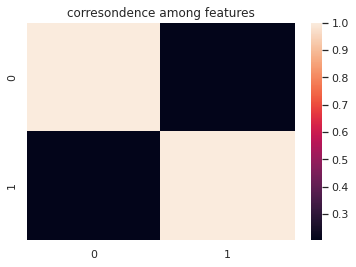

In [64]:
vec1 = data_2_post['score'].to_list()
vec2 = data_2_post['comms_num'].to_list()

import numpy as np

corr = np.corrcoef(vec1, vec2)
print(corr)

# use a heatmap to show the relationship among those features
sns.set()

fig = plt.figure()
plt.title('corresondence among features')
sns_plot = sns.heatmap(corr)
plt.show()

Next, we decided that it is important to look into the words within the title and found out their effects on score/comment numbers. Before doing so, we first need to normalize the score and comment number since they were originally having huge range. We choice to use min-max normalization in this part.

In [65]:
# Current dataframe is data_2_post, count the frequency and add the score at the same time
# Normalize it using min-max normalization
from sklearn import preprocessing

x = data_2_post[['score','comms_num']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
norm = pd.DataFrame(x_scaled)
preprocessed = pd.concat([data_2_post['title'], norm], axis=1)
preprocessed = preprocessed.rename(columns={0:"score", 1:"comms_num"})
preprocessed.dropna()


,title,score,comms_num
0,Times Square right now,1.000000,0.123880
1,GME YOLO update — Jan 28 2021,0.648603,0.249914
2,GME YOLO month-end update — Jan 2021,0.631112,0.215562
3,GME YOLO update — Feb 19 2021,0.577669,0.137732
4,It’s treason then,0.562203,0.048495
...,...,...,...
45417,"Unpinned Daily Discussion Thread for April 14,...",0.000000,0.018281
45418,DADDY JACK MA PRINTING,0.000000,0.000075
45419,$SDC (SmileDirectClub),0.000000,0.000161
45420,20 DOCU 5/21 250 C + 200 DOCU 5/21 280 C + 50 ...,0.000000,0.000032


Then, we get rid of all the special characters in each title, and only leave valid words within each title.

In [66]:
#Get rid of all the special characters in each title
import regex as re
preprocessed['title'].astype(str)
preprocessed['title'] = preprocessed['title'].apply(lambda x: re.sub(r'[^\w]', ' ', x))
preprocessed['title']

0                                   Times Square right now
1                            GME YOLO update   Jan 28 2021
2                     GME YOLO month end update   Jan 2021
3                            GME YOLO update   Feb 19 2021
4                                        It s treason then
                               ...                        
45417    Unpinned Daily Discussion Thread for April 14 ...
45418                               DADDY JACK MA PRINTING
45419                                SDC  SmileDirectClub 
45420    20 DOCU 5 21 250 C   200 DOCU 5 21 280 C   50 ...
45421    Liquidated all BB shares started IWM short pos...
Name: title, Length: 45422, dtype: object

It is now time to count the word frequency! In the following part, we first set the stopwords for all the titles, and weight the word frequency based on the score of each post.

In [ ]:
from collections import defaultdict
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
word_freq = defaultdict(lambda: [0, 0]) 
all_stopwords = stopwords.words('english')
stopword_list = ['i', 'we','us', 'a','like','play', 'our', 'do']
all_stopwords.extend(stopword_list)

# looping is now over both the text and the numbers
for index, row in preprocessed.iterrows(): 
  text_tokens = word_tokenize(row['title'])
  row['title'] = [word for word in text_tokens if not word.lower() in all_stopwords]
  for word in row['title']: 
      # same as before
      word_freq[word][0] += 1 
      # new line, incrementing the numeric value for each word
      word_freq[word][1] += row['score']

columns = {0: 'abs_freq', 1: 'wtd_freq'}

abs_wtd_df = pd.DataFrame.from_dict(word_freq, orient='index') \
             .rename(columns=columns) \
             .sort_values('wtd_freq', ascending=False) \
             .assign(rel_value=lambda df: df['wtd_freq'] / df['abs_freq']) \
            .round()

abs_wtd_df.style.background_gradient(low=0, high=.7, subset=['rel_value'])

Here, we make a statistic of absolute and weighted frequency. To add more information, we counted the cumulative of both frequencies, and the percentage of each word. As we can see from the result, GME and AMC are both optaining top 5 heat words in wallstreetbets in the first 4 month of 2021.

In [71]:
abs_wtd_df.insert(1, 'abs_perc', value=abs_wtd_df['abs_freq'] / abs_wtd_df['abs_freq'].sum())
abs_wtd_df.insert(2, 'abs_perc_cum', abs_wtd_df['abs_perc'].cumsum())
abs_wtd_df.insert(4, 'wtd_freq_perc', abs_wtd_df['wtd_freq'] / abs_wtd_df['wtd_freq'].sum())
abs_wtd_df.insert(5, 'wtd_freq_perc_cum', abs_wtd_df['wtd_freq_perc'].cumsum())
abs_wtd_df.style.background_gradient(low=0, high=0.8)
abs_wtd_df.head(20)

,abs_freq,abs_perc,abs_perc_cum,wtd_freq,wtd_freq_perc,wtd_freq_perc_cum,rel_value
GME,8314,0.028812,0.028812,47.0,0.061680,0.061680,0.0
WSB,973,0.003372,0.032184,12.0,0.015748,0.077428,0.0
2021,649,0.002249,0.034433,10.0,0.013123,0.090551,0.0
GameStop,589,0.002041,0.036474,7.0,0.009186,0.099738,0.0
YOLO,1043,0.003614,0.040088,6.0,0.007874,0.107612,0.0
AMC,3062,0.010611,0.050699,5.0,0.006562,0.114173,0.0
update,290,0.001005,0.051704,5.0,0.006562,0.120735,0.0
shares,1343,0.004654,0.056358,5.0,0.006562,0.127297,0.0
Robinhood,2296,0.007957,0.064315,5.0,0.006562,0.133858,0.0
stock,1343,0.004654,0.068969,5.0,0.006562,0.140420,0.0


###**Data Set 1**
Now, we look at Data set 1. This is the larger data set with 200MB, we therefore did not do deep EDA on this one.

In [ ]:
# clear some useless data

query = '''
SELECT * FROM data_1_df
WHERE
id IS NOT NULL
AND
title IS NOT NULL
AND
score IS NOT NULL
AND
author IS NOT NULL
AND
created_utc IS NOT NULL
AND
num_comments IS NOT NULL
'''

data_1_clean = ps.sqldf(query, locals())

In [ ]:
# if a post is removed by someone, then it can be classified as removed, which is much easier for a computer to understand than some names.

data_1_clean['removed'] = data_1_clean['removed_by'].apply(to_binary)

print(data_1_clean[['author', 'author_flair_text','removed', 'total_awards_received']])

                   author author_flair_text  removed  total_awards_received
0                Zaccko98              None        1                    0.0
1               toutoucnc       210115:1:1        1                    0.0
2                  thabat              None        1                    0.0
3             AsianTwink_              None        1                    0.0
4          Oneverystreet8              None        1                    0.0
...                   ...               ...      ...                    ...
1118857  secondhandsondek              None        0                    NaN
1118858         [deleted]              None        0                    NaN
1118859         [deleted]              None        0                    NaN
1118860         [deleted]              None        0                    NaN
1118861         [deleted]              None        0                    NaN

[1118862 rows x 4 columns]


We decide to drop all the posts taht are already removed, which have \[deleted] as title.

In [ ]:
# also clear the posts from users who deleted their account

query = '''
SELECT * FROM data_1_clean
WHERE author IS NOT '[deleted]'
'''

data_1_not_del = ps.sqldf(query, locals()).fillna(0)

In [ ]:
data_1_not_del

,id,title,score,author,author_flair_text,removed_by,total_awards_received,awarders,created_utc,full_link,num_comments,over_18,removed
0,ll0n5k,Whats going on with PLTR?,1,Zaccko98,0,moderator,0.0,[],1613469192,https://www.reddit.com/r/wallstreetbets/commen...,2,0,1
1,ll0n4p,"Need explanations on Level 2 data for GME, why...",1,toutoucnc,210115:1:1,moderator,0.0,[],1613469189,https://www.reddit.com/r/wallstreetbets/commen...,2,0,1
2,ll0my2,XRT is being used as a laundry short machine,1,thabat,0,moderator,0.0,[],1613469166,https://www.reddit.com/r/wallstreetbets/commen...,2,0,1
3,ll0mxr,Airlines?,1,AsianTwink_,0,moderator,0.0,[],1613469165,https://www.reddit.com/r/wallstreetbets/commen...,2,0,1
4,ll0mx4,Buy TRXC 🚀,1,Oneverystreet8,0,moderator,0.0,[],1613469164,https://www.reddit.com/r/wallstreetbets/commen...,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037323,sr5dr,since r/investing is on all aapl all the time ...,8,entsportsjunkie,0,0,0.0,0,1335323552,https://www.reddit.com/r/wallstreetbets/commen...,20,0,0
1037324,sqd7j,PNRA - Panera Breads earnings tonight (4/24),4,secondhandsondek,0,0,0.0,0,1335293453,https://www.reddit.com/r/wallstreetbets/commen...,3,0,0
1037325,sohin,NFLX bear coming out of hibernation. Earnings ...,7,secondhandsondek,0,0,0.0,0,1335204052,https://www.reddit.com/r/wallstreetbets/commen...,13,0,0
1037326,sinsk,"After HGSI spikes 97%, will share price drop a...",4,CheeseYogi,0,0,0.0,0,1334877676,https://www.reddit.com/r/wallstreetbets/commen...,0,0,0


In [ ]:
print(data_1_df.columns)

Index(['id', 'title', 'score', 'author', 'author_flair_text', 'removed_by',
       'total_awards_received', 'awarders', 'created_utc', 'full_link',
       'num_comments', 'over_18'],
      dtype='object')


In [ ]:
# Author with most awards / score

query = '''
SELECT author, count(score) as num_post, avg(score) as mean_score,avg(num_comments) as mean_comms, avg(removed) as ratio_removed, avg(total_awards_received) as mean_awards FROM data_1_not_del
GROUP BY author
ORDER BY mean_score DESC
'''

data_1_author = ps.sqldf(query, locals())
data_1_author = data_1_author.fillna(0)

In [ ]:
data_1_author

,author,num_post,mean_score,mean_comms,ratio_removed,mean_awards
0,Lansman,1,107196.0,6810.0,0.0,571.0
1,Greenzone51,1,97512.0,5435.0,1.0,431.0
2,Darlink23,1,91846.0,4539.0,0.0,334.0
3,chubbygroundhog,1,90444.0,2361.0,0.0,445.0
4,HistoryGuardian,1,71796.0,4379.0,0.0,173.0
...,...,...,...,...,...,...
475752,zuggra,1,0.0,1.0,0.0,0.0
475753,zuurstok420goodbeer,1,0.0,13.0,0.0,0.0
475754,zwondingo,1,0.0,0.0,1.0,0.0
475755,zzer08ight,1,0.0,0.0,1.0,0.0


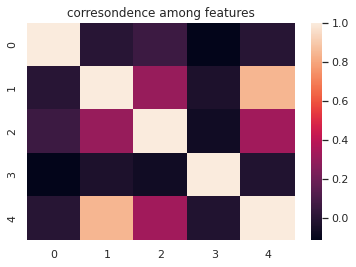

In [ ]:
# feature vectors

vec1 = data_1_author['num_post'].to_list()
vec2 = data_1_author['mean_score'].to_list()
vec3 = data_1_author['mean_comms'].to_list()
vec4 = data_1_author['ratio_removed'].to_list()
vec5 = data_1_author['mean_awards'].to_list()

import numpy as np

corr = np.corrcoef([vec1, vec2, vec3, vec4, vec5])
# print(corr)

# use a heatmap to show the relationship among those features

fig = plt.figure()
plt.title('corresondence among features')
sns_plot = sns.heatmap(corr)
plt.show()

In [ ]:
query = '''
SELECT * FROM data_1_author
ORDER BY num_post DESC
'''

data_1_num_post = ps.sqldf(query, locals())

In [ ]:
data_1_num_post

,author,num_post,mean_score,mean_comms,ratio_removed,mean_awards
0,AutoModerator,2403,54.204744,6597.935081,0.000416,0.902622
1,WSBVoteBot,1461,1.048597,9.547570,0.000000,0.000000
2,WSBConsensus,843,108.945433,31.817319,0.020166,0.015421
3,londonistani,549,41.336976,14.562842,0.001821,0.000000
4,StockPollsEnterprise,503,29.854871,13.174950,0.007952,0.000000
...,...,...,...,...,...,...
475752,zuggra,1,0.000000,1.000000,0.000000,0.000000
475753,zuurstok420goodbeer,1,0.000000,13.000000,0.000000,0.000000
475754,zwondingo,1,0.000000,0.000000,1.000000,0.000000
475755,zzer08ight,1,0.000000,0.000000,1.000000,0.000000


### **Modeling**

In this part we are going to explore the dataset with several models to reveal the interrelationship between the features and the post itself. Firstly we applied a tf-idf as preprocessing to get the weighted word frequency of the keywords for further exploration

In [ ]:
from nltk.tokenize import sent_tokenize
import nltk.data
from nltk.tokenize import word_tokenize
nltk.download('punkt')
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Firstly we analized dataset2, the smaller dataset containg about 45k posts.

In [ ]:
# Keyword with most scores 
# TF-IDF (keyword scoring model)
# Dataset 2

from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
X = data_2_post['title'].fillna('')
from nltk.corpus import stopwords



import numpy as np
import random
import os
import torch

# set the random seed to ensure everyone can get the same result with the code
def seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False

seed()

# use max_df to filter common words like and, or, ect, and min_df to filter worthless words that showed up for less than a certain times
all_stopwords = stopwords.words('english')

vectorizer = TfidfVectorizer(max_df=0.1, min_df=0.0005, stop_words=all_stopwords)
features = vectorizer.fit_transform(X)
words = vectorizer.get_feature_names()

print(words)

# original dictionary length: 19861
# after some filering
print(len(words))

# split the dataset
label = data_2_post[['score', 'comms_num']]

X_train,X_test,y_train,y_test = train_test_split(features,label,test_size=0.2,train_size=0.8, random_state = 0)

del features

['00', '000', '01', '02', '03', '05', '08', '09', '10', '100', '1000', '100k', '10k', '11', '12', '120', '12k', '13', '130', '14', '15', '150', '15k', '16', '17', '18', '19', '19th', '1k', '1m', '1st', '20', '200', '2000', '2008', '200k', '2020', '2021', '20k', '21', '212', '22', '23', '24', '25', '250', '25k', '26', '27', '28', '29', '2k', '30', '300', '30k', '31', '320', '33', '35', '350', '3k', '3rd', '40', '400', '401k', '40k', '42', '420', '45', '4k', '50', '500', '5000', '500k', '50k', '53', '55', '5g', '5k', '60', '600', '65', '69', '6k', '70', '700', '75', '7k', '80', '800', '85', '8k', '90', '99', '9th', 'aal', 'aapl', 'ability', 'able', 'aboard', 'absolute', 'absolutely', 'access', 'according', 'account', 'accounts', 'across', 'act', 'action', 'actions', 'activity', 'actual', 'actually', 'add', 'added', 'adding', 'advice', 'advisor', 'af', 'afford', 'afraid', 'ag', 'ago', 'agree', 'ah', 'ahead', 'aint', 'airlines', 'aka', 'alert', 'alive', 'allow', 'allowed', 'allowing', 'all

In [ ]:
X_train.shape

(36338, 1732)

Since the feature is high dimensional, i firstly tried apply pca upon it to see if there will be any benefit, however it seems that pca will only make things worse, since we got a correspondense of 0.65 between prediction and ground truth without pca, but a correspondense of 0.06 with it.(Ridge regression) Therefore no PCA will be conducted to the features in our further experiment.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

# pca = PCA(n_components=32)
# pca = SparsePCA(n_components=32, random_state=0)
# pca.fit(X_train.toarray())
# X_train = pca.transform(X_train.toarray())
# X_test = pca.transform(X_test.toarray())

# preprocess the data and prepare them for the models
X_train = X_train.toarray()
X_test = X_test.toarray()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

score_train = y_train[:,0]
comments_train = y_train[:,1]

score_test = y_test[:,0]
comments_test = y_test[:,1]

After some simple preprocessing, I applied ridge regression upon the dataset to see if we can predict the score that a post would get given its title using the ridge regression algorithm

In [ ]:
# ridge regression
# predict score/ number of response

ri = Ridge(alpha=0.5)
ri.fit(X_train, y_train)
y_pred = ri.predict(X_test)

corr_1 = np.corrcoef(y_pred[:,0],y_test[:,0])[0,1]
corr_2 = np.corrcoef(y_pred[:,1],y_test[:,1])[0,1]
# print(corr_1, corr_2)
print('Correlation coefficients of the predicted score a post will get and the ground truth:')
print(corr_1)
print('Correlation coefficients of the number of responses a post will get and the ground truth:')
print(corr_2)

Correlation coefficients of the predicted score a post will get and the ground truth:
0.12789195654141988
Correlation coefficients of the number of responses a post will get and the ground truth:
0.6505743228652913


Since its a regression task, we dicide to use the  correlation coefficients as the evalution matric to evaluate how good the model is. It seems that the title, or at least the keywords have little to do with the score of a post, but have great influence upon the number of responses that a post will get. Here are some examples.

In [ ]:
# lowest predicted posts: no.5201 5738 7608
# highest predicted posts: no.3393 7718 7290

print('posts that is predicted to get a lot of responses:')

for idx in [3393, 7718, 7290]:
  post = data_2_post.loc[idx][['title', 'score',	'comms_num']].to_list()
  print('title:', post[0],'score:', post[1],'responses:',post[2])
  print('\n')
  print('predicted score:', int(y_pred[idx,0]), 'predicted responses:' , int(y_pred[idx,1]))
  print('---------')

print('\n\n\n')  
print('posts that is predicted to be ignored:')

for idx in [5201, 5738, 7608]:
  post = data_2_post.loc[idx][['title', 'score',	'comms_num']].to_list()
  print('title:', post[0],'score:', post[1],'responses:',post[2])
  print('\n')
  print('predicted score:', int(y_pred[idx,0]), 'predicted responses:' , int(y_pred[idx,1]))
  print('---------')

posts that is predicted to get a lot of responses:
title: I’m tired of people saying “it’s okay to sell, we have to respect those who want off this ride”. FUCKIN RIDE OR DIE, DIAMOND HANDS BABY 💎🙌👶 🚀🚀🚀 score: 1979 responses: 153


predicted score: 18557 predicted responses: 31500
---------
title: AMRS Gains March 22, 2021 score: 389 responses: 70


predicted score: 18557 predicted responses: 31500
---------
title: "An empire toppled by its enemies can rise again, but one which crumbles from within - that's dead forever." score: 433 responses: 26


predicted score: 15895 predicted responses: 31765
---------




posts that is predicted to be ignored:
title: The Super Squeeze: Media Day score: 829 responses: 37


predicted score: -5912 predicted responses: -5056
---------
title: In Germany we dont say sell - we say hold💎🦍 score: 679 responses: 33


predicted score: -3646 predicted responses: -4364
---------
title: Hodlers gonna hodl! score: 400 responses: 23


predicted score: -2924 predi

As we can see, the posts that are prediceted to be welcoming actually received lots of responses, and vice versa, though the magnitude of the prediction is exaggerate and inrealistic (because we are showing the extreme examples). And we can also observe that those hot posts are actually all about a specific and attracting topic, like complaining about advertisements or information about stock, etc.

The next model we tried is a multi layer neural net, which has three linear layers and uses prelu as the activation funcion, and batchnormalization to prevent overfit and backprop problems. To train the network, we used MSE (mean square error) loss and Adam optimizer with a initial learning rate of 0.01

In [ ]:
# neural net
# predict score/ number of response/ stock prize/ possibility of being removed

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

class net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(net, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.l1 = nn.Sequential(
            nn.BatchNorm1d(self.input_dim),
            torch.nn.Linear(input_dim, 128),
            nn.PReLU(),
            nn.BatchNorm1d(128),
         )
        self.l2 = nn.Sequential(
            torch.nn.Linear(128, 64),
            nn.PReLU(),
            nn.BatchNorm1d(64),
         )
        self.l3 = nn.Sequential(
            torch.nn.Linear(64, self.output_dim),
         )
        self.relu = nn.Sequential(
            nn.ReLU(inplace=True),
         )

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        # x = x.view(x.shape[0],-1)
        y_pred = self.relu(x)
        return y_pred


input_dim = X_train.shape[1]### fill in the input dim

# function to train a network
def train_model(model, optimizer, criterion, epochs=100, report_frequency = 1):
    
    model.to(device)
    model.train()

    loss_list = []
    for epoch in range(epochs):
      num = 0
      epoch_loss = None 
      for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        pred = model(data)     
        loss = criterion(pred, label).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        try:
          epoch_loss += loss.item()
        except:
          epoch_loss = loss.item()


        num += label.shape[0]

      loss_list.append(epoch_loss/num)
      if epoch%report_frequency ==report_frequency-1:
        print('epoch: ', epoch + 1, ' loss: ', epoch_loss/num)

    final_training_loss = loss_list[-1]
    return model, loss_list

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.MSELoss(reduce=False, size_average=False)

Build the dataloader and train the network for 100 epochs:

In [ ]:
seed(1)

# train the model for 100 epochs
train_loader =  DataLoader(TensorDataset(torch.tensor(X_train).float(),torch.tensor(y_train).float()),shuffle = True,batch_size=512)
test_loader =  DataLoader(TensorDataset(torch.tensor(X_test).float(),torch.tensor(y_test).float()),shuffle = False,batch_size=128)

nn_model = net(input_dim, 2)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)

model, loss_list = train_model(nn_model, nn_optimizer, criterion, 100, 10)

epoch:  10  loss:  53097354.969013155
epoch:  20  loss:  31315566.493257746
epoch:  30  loss:  25628431.71732071
epoch:  40  loss:  21870845.724475756
epoch:  50  loss:  19405830.326380096
epoch:  60  loss:  17887255.882437117
epoch:  70  loss:  16970283.55550663
epoch:  80  loss:  17163830.528042268
epoch:  90  loss:  16019187.400077054
epoch:  100  loss:  15233211.424294127


The training loss curve:

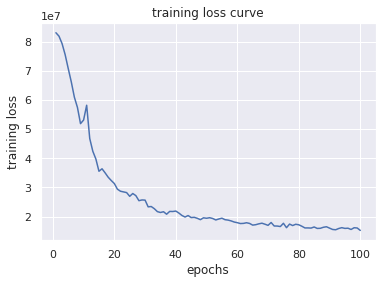

In [ ]:
epochs = torch.linspace(1,100,100)
plt.figure()
plt.plot(epochs, loss_list)
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.title('training loss curve')
plt.show()

Test the model and check the correspondence between the prediction and the ground truth.

In [ ]:
# function to test a model

def test_model(model, criterion):
    model.eval()

    testing_loss = 0
    num = 0
    predcitons = []
    with torch.no_grad():
      for data, label in test_loader:
        data = data.to(device)
        label = label.to(device)
        pred = model(data)
        loss = criterion(pred, label).sum()
        testing_loss += loss.item()
        num += label.shape[0]
        predcitons.append(pred)
    testing_loss /= num
    return  testing_loss, torch.cat(predcitons)

testing_loss, predcitons = test_model(model, criterion)


corr_1 = np.corrcoef(predcitons[:,0],y_test[:,0])[0,1]
corr_2 = np.corrcoef(predcitons[:,1],y_test[:,1])[0,1]
print('Correlation coefficients of the predicted score a post will get and the ground truth:')
print(corr_1)
print('Correlation coefficients of the number of responses a post will get and the ground truth:')
print(corr_2)

Correlation coefficients of the predicted score a post will get and the ground truth:
0.07230480545759127
Correlation coefficients of the number of responses a post will get and the ground truth:
0.7139044694635915


As we can see, the model still learns little about the score of a post, but performs better in predicting the number of responses of a post (improved by about 0.06). We print out some examples.

In [ ]:
print('posts that is predicted to get a lot of responses:')

for idx in [7290, 2468, 5256]:
  print(idx)
  post = data_2_post.loc[idx][['title', 'score', 'comms_num']].to_list()
  print('title:', post[0],'score:', post[1],'responses:',post[2])
  print('\n')
  print('predicted score:', int(predcitons[idx,0]), 'predicted responses:' , int(predcitons[idx,1]))
  print('---------')

print('\n\n\n')  
print('posts that is predicted to be ignored:')

for idx in [  0, 5870, 5869]:
  post = data_2_post.loc[idx][['title', 'score', 'comms_num']].to_list()
  print('title:', post[0],'score:', post[1],'responses:',post[2])
  print('\n')
  print('predicted score:', int(predcitons[idx,0]), 'predicted responses:' , int(predcitons[idx,1]))
  print('---------')

posts that is predicted to get a lot of responses:
7290
title: "An empire toppled by its enemies can rise again, but one which crumbles from within - that's dead forever." score: 433 responses: 26


predicted score: 31438 predicted responses: 106028
---------
2468
title: $GME and $RKT SHORT SELLING NOT ALLOWED ON TD score: 3809 responses: 922


predicted score: 37735 predicted responses: 110364
---------
5256
title: $CRSR Corsair DD / Earnings play score: 810 responses: 89


predicted score: 29864 predicted responses: 212015
---------




posts that is predicted to be ignored:
title: Times Square right now score: 348241 responses: 11554


predicted score: 0 predicted responses: 0
---------
title: This was just funny! Texans, VOTE GONZALEZ!!! score: 652 responses: 46


predicted score: 0 predicted responses: 0
---------
title: I’m very pissed. But I bought 20 more shares today. I’m not fucking. Selling ... period. If we’re wrong we’re wrong, I feel like Jordan Belford and mark cuban are

As we can see, two models actually gets quite similar results, as the attracting topics about stocks and phelosophy gets high predictions, and adverts and long boring stories get poor predictions.

Now we look at the dataset1, the larger dataset which have about 1 million posts from about 470 thousand authors. For this dataset we analized the interrelationship among five of its featurs: number of post from an author, the average score, comments the author get per post, how many of his/her post were removed and the average award that the author get per post.

Fristly lets glance at the dataset, it can be seen that most authors actually only posted 1 post.

In [ ]:
data_1_author

,author,num_post,mean_score,mean_comms,ratio_removed,mean_awards
0,Lansman,1,107196.0,6810.0,0.0,571.0
1,Greenzone51,1,97512.0,5435.0,1.0,431.0
2,Darlink23,1,91846.0,4539.0,0.0,334.0
3,chubbygroundhog,1,90444.0,2361.0,0.0,445.0
4,HistoryGuardian,1,71796.0,4379.0,0.0,173.0
...,...,...,...,...,...,...
475752,zuggra,1,0.0,1.0,0.0,0.0
475753,zuurstok420goodbeer,1,0.0,13.0,0.0,0.0
475754,zwondingo,1,0.0,0.0,1.0,0.0
475755,zzer08ight,1,0.0,0.0,1.0,0.0


We now want to study how many awards will someone get from a post given his history record of followers, score, etc.

In [ ]:
# predcite how many awards will an author receive

features = data_1_author[['num_post', 'mean_score', 'mean_comms','ratio_removed']]

label = data_1_author['mean_awards']

# the dataset is toooooo large so I only used part of it, otherwise the grid search will take literaly a year
X_train,X_test,y_train,y_test = train_test_split(features,label,test_size=0.1,train_size=0.1, random_state = 0)

In [ ]:
print(X_train.shape)

(4757, 4)


I used SVR to perform the prediction, and used grid search to find the best set of hyperparameters. This is super time-costy as it took me hours to run.

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

model = GridSearchCV(SVR(), param_grid={"kernel": ("linear", 'rbf', 'sigmoid'), "C": np.logspace(-3, 3, 3), "gamma": np.logspace(-3, 3, 3)})
model.fit(X_train, y_train)

y_pre = model.predict(X_test)

corr = np.corrcoef(y_pre,y_test)[0,1]

print('Correlation coefficients of the prediction and the ground truth:')
print(corr)
print('The mean square error of the prediction')
print(np.sum(np.square(y_pre-y_test))/y_test.shape[0])

Correlation coefficients of the prediction and the ground truth:
0.35276220515882833
The mean square error of the prediction
5.115780427508329


As we can see, the prediction is to some extent have the same trend with the ground truth, but the correlation coefficients suggests that the result is far from accurate. Here are some of the examples:

In [ ]:
import random

i = 0
j = 0
while(i+j < 10 and i< 8):
  idx = random.randint(0,y_test.shape[0]-1)
  if y_test.to_numpy()[idx]> 0:
    print('ground truth:', y_test.to_numpy()[idx], 'prediction:', y_pre[idx])
    i += 1
  elif j<2:
    print('ground truth:', y_test.to_numpy()[idx], 'prediction:', y_pre[idx])
    j += 1

ground truth: 0.0 prediction: 0.09949781483236242
ground truth: 0.0 prediction: 0.0997972033855854
ground truth: 0.2727272727272727 prediction: 0.09676724037381179
ground truth: 0.3333333333333333 prediction: 0.09910831570566137
ground truth: 1.0 prediction: 0.0983391312737667
ground truth: 1.0 prediction: 0.0979122713988918
ground truth: 0.125 prediction: 0.09776055582568777
ground truth: 7.0 prediction: 0.10227396374430375
ground truth: 4.0 prediction: 1.6781969902027327
ground truth: 1.0 prediction: 0.13819209455963666


As we can see, the result is kind of inaccurate, so i looked back into the dataset:

In [ ]:
import random

for i in range(10):
  idx = random.randint(0,y_test.shape[0]-1)
  print('ground truth:', y_test.to_numpy()[idx], 'prediction:', y_pre[idx])

ground truth: 0.0 prediction: 0.0997972033855854
ground truth: 0.0 prediction: 0.0999777372873738
ground truth: 0.0 prediction: 0.0999777372873738
ground truth: 0.0 prediction: 0.09973950507355456
ground truth: 0.0 prediction: 0.09979509538798093
ground truth: 0.0 prediction: 0.099893538848419
ground truth: 0.0 prediction: 0.0991108486042318
ground truth: 0.0 prediction: 0.09966943396921968
ground truth: 0.0 prediction: 0.0999777372873738
ground truth: 0.0 prediction: 0.09882069887331646


It seems that there most authors acutually never got any award, so the data is super inbalance. In this case we manually balanced the data and run the model again.

In [ ]:
import random

i = 0
j = 0
idxlist = []

X_train,X_test,y_train,y_test = train_test_split(features,label,test_size=0.1,train_size=0.9, random_state = 0)

posidx = np.where(y_train.to_numpy()>0)[0]
num = posidx.shape[0]

print('number of positive examples:', num)

# so we select 4000 examples each
while(i < 4000 and i< 4000):
  idx = random.randint(0,y_train.shape[0]-1)
  if y_train.to_numpy()[idx]> 0 and i < 4000 and idx not in idxlist:
    idxlist.append(idx)
    i += 1
  if y_train.to_numpy()[idx]== 0 and j < 4000 and idx not in idxlist:
    idxlist.append(idx)
    j += 1

X_train = X_train.to_numpy()[idxlist]
y_train = y_train.to_numpy()[idxlist]

number of positive examples: 4846


Train the model again:

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

model = GridSearchCV(SVR(), param_grid={"kernel": ("linear", 'rbf', 'sigmoid'), "C": np.logspace(-3, 3, 3), "gamma": np.logspace(-3, 3, 3)})
model.fit(X_train, y_train)

y_pre = model.predict(X_test)

corr = np.corrcoef(y_pre,y_test)[0,1]

print('Correlation coefficients of the prediction and the ground truth:')
print(corr)
print('The mean square error of the prediction')
print(np.sum(np.square(y_pre-y_test))/y_test.shape[0])

Correlation coefficients of the prediction and the ground truth:
0.5153291542860472
The mean square error of the prediction
4.039775283566279


The result looks much better than it was before the balance.

And also, I applied linear regression (because its computational cheaper and we are running out of time lol. It tooks hours for us to run a neural net on such a big dataset each time) to predict whether a post will be removed given its score, number of comments, etc. Sigmoid is applied here to make the prediction a valid possibility.

In [ ]:
# logistic regression
# predict whether an author's post will be removed (1 for 100 precent, 0 otherwise)

from sklearn.linear_model import LinearRegression

lr=LinearRegression()
lr.fit(X_train,y_train)

y_pre=torch.sigmoid(torch.Tensor(lr.predict(X_test)))
y_pre = np.array(y_pre)

corr = np.corrcoef(y_pre,y_test)[0,1]
print('Correlation coefficients of the prediction and the ground truth:')
print(corr)
print('The mean square error of the prediction')
print(np.sum(np.square(y_pre-y_test))/y_test.shape[0])

Correlation coefficients of the prediction and the ground truth:
0.1905829102511312
The mean square error of the prediction
5.503592427776303


As we can see, the linear regression model performs poorly even if it is using the same set of data, which suggests that the data has a strong non-linearity 

### **Difficulties**

We also tried to extract the information from the titles of dataset 1 and do some exciting thing, such as find the relationship between the keyword frequency (which contains stock name) and the stock prize over time, however as the dataset is overwhelmingly large we find it too time-consuming and computational costy to do predictions with the word frequency of dataset 1. I acutually experienced stack overflow when I tried to apply adaboost on it to predict whether a post will be removed. 

The following codes are part of the exploration we tried, and we dicied to just leave it this way because of time. Given better computaiton resorce (like colab pro) and one more week, we might be able to do some super exciting thing with it.

In [ ]:
X = data_1_not_del['title']

vectorizer = TfidfVectorizer(max_df=0.1, min_df=0.0005, stop_words=all_stopwords)
features = vectorizer.fit_transform(X)
words = vectorizer.get_feature_names()

print(words)
print(len(words))

label = data_1_not_del[['removed']]

X_train,X_test,y_train,y_test = train_test_split(features,label,test_size=0.2,train_size=0.8, random_state = 0)

del features

In [ ]:
# Adaboost
# predict whether a post will be removed (1 for removed, 0 otherwise)
# hyperparameter: max_depth, min_samples_split, min_samples_leaf, algorithm, n_estimators, learning_rate

bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, min_samples_split=20, min_samples_leaf=5),
                         algorithm="SAMME",
                         n_estimators=200, learning_rate=0.8)
bdt.fit(X_train, y_train)

pred = bdt.predict(X_test)

corr = np.corrcoef(y_pre[:,0],y_test)[0,1]
print(corr)

print(torch.nn.MSELoss(y_pre, y_test))

##**Future Implementation**
We wanted to tried out rnn model, which was specilized in analyzing the texts and is believed to give more accurate predictions. However we found it really hard to implement, especially for starters like us. For future implementations, we think rnn would be the correct direction to work on, and it would also be interesting to focus on stock price verses post about stocks over time. 